[View in Colaboratory](https://colab.research.google.com/github/rorycawley/DissertationCA2/blob/master/Rory_Final_Stacked_GRU_50.ipynb)

**Resets the VM**

In [0]:
#!kill -9 -1

**Installs and environment detection**



In [2]:
!pip show tensorflow

Name: tensorflow
Version: 1.7.0
Summary: TensorFlow helps the tensors flow
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: astor, absl-py, numpy, grpcio, termcolor, tensorboard, wheel, six, gast, protobuf
Required-by: 


In [3]:
!pip show keras

Name: Keras
Version: 2.1.6
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, six, numpy, pyyaml, h5py
Required-by: 


In [4]:
!pip install wtte

In [5]:
!pip install tqdm

In [6]:
!uname -or

4.4.111+ GNU/Linux


In [7]:
!gcloud version

Google Cloud SDK 199.0.0
alpha 2017.09.15
beta 2017.09.15
bq 2.0.33
core 2018.04.20
gsutil 4.30


In [8]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  print(tf.test.gpu_device_name())

GPU device not found


In [9]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9202069468450913492]

In [10]:
!cat /proc/meminfo

MemTotal:       13341832 kB
MemFree:          188940 kB
MemAvailable:   11510628 kB
Buffers:          149316 kB
Cached:         10824460 kB
SwapCached:            0 kB
Active:          3026748 kB
Inactive:        9433120 kB
Active(anon):    1486464 kB
Inactive(anon):      284 kB
Active(file):    1540284 kB
Inactive(file):  9432836 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               388 kB
Writeback:             0 kB
AnonPages:       1486040 kB
Mapped:           212184 kB
Shmem:               668 kB
Slab:             627244 kB
SReclaimable:     601984 kB
SUnreclaim:        25260 kB
KernelStack:        3584 kB
PageTables:         8880 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6670916 kB
Committed_AS:    2847812 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
HugePages_Total: 

In [11]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc eagerfpu pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm kaiser fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms xsaveopt
bugs		:
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache s

In [0]:
def connectWithGDrive():
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
  return

# Comment this out if you're already able authed to load and save files
#connectWithGDrive()

#!mkdir -p drive
#!google-drive-ocamlfuse drive

**Import numpy and pandas (to work with the csv file) and matplotlib for visualisation**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
PYTHONHASHSEED = 0

**Set column names for the training and test data**

In [14]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols
column_names

['unit_number',
 'time',
 'op_setting_1',
 'op_setting_2',
 'op_setting_3',
 'sensor_measurement_1',
 'sensor_measurement_2',
 'sensor_measurement_3',
 'sensor_measurement_4',
 'sensor_measurement_5',
 'sensor_measurement_6',
 'sensor_measurement_7',
 'sensor_measurement_8',
 'sensor_measurement_9',
 'sensor_measurement_10',
 'sensor_measurement_11',
 'sensor_measurement_12',
 'sensor_measurement_13',
 'sensor_measurement_14',
 'sensor_measurement_15',
 'sensor_measurement_16',
 'sensor_measurement_17',
 'sensor_measurement_18',
 'sensor_measurement_19',
 'sensor_measurement_20',
 'sensor_measurement_21']

**Use pandas to read in the csv files**

In [0]:
# read training data
#train_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv', header=None, names=column_names, index_col=['unit_number', 'time'])
train_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv', header=None, names=column_names)


# read test data
#test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv', header=None, names=column_names, index_col=['unit_number', 'time'])
test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv', header=None, names=column_names)


# read ground truth data
test_y_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_y.csv', header=None, names=['T'])

In [16]:
# Change the index to be Engine and Cycle Time
train_orig.set_index(['unit_number', 'time'], verify_integrity=True)
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1           0.0023        0.0003         100.0   
            2          -0.0027       -0.0003         100.0   
            3           0.0003        0.0001         100.0   
            4           0.0042        0.0000         100.0   
            5           0.0014        0.0000         100.0   
            6           0.0012        0.0003         100.0   
            7          -0.0000        0.0002         100.0   
            8           0.0006       -0.0000         100.0   
            9          -0.0036        0.0000         100.0   
            10         -0.0025       -0.0001         100.0   
            11          0.0007       -0.0004         100.0   
            12          0.0026        0.0003         100.0   
            13         -0.0056        0.0003         100.0   
            14          0.0017       -0.0004         100.0   
            15         -0.0003       -0.0003         100.0   
            16         -0.0018        0.0003         100.0   
            17          0.0014        0.0002         100.0   
            18          0.0035        0.0001         100.0   
            19          0.0029        0.0001         100.0   
            20          0.0011       -0.0001         100.0   
            21          0.0038       -0.0002         100.0   
            22          0.0012        0.0001         100.0   
            23          0.0009       -0.0000         100.0   
            24         -0.0006       -0.0001         100.0   
            25          0.0028       -0.0003         100.0   
            26          0.0047       -0.0005         100.0   
            27         -0.0007        0.0001         100.0   
            28          0.0022        0.0005         100.0   
            29          0.0014        0.0001         100.0   
            30         -0.0025        0.0004         100.0   
...                        ...           ...           ...   
100         169         0.0026       -0.0000         100.0   
            170        -0.0006       -0.0004         100.0   
            171        -0.0026       -0.0003         100.0   
            172         0.0007        0.0003         100.0   
            173        -0.0003       -0.0000         100.0   
            174        -0.0005        0.0003         100.0   
            175         0.0019        0.0000         100.0   
            176         0.0002        0.0002         100.0   
            177        -0.0041       -0.0003         100.0   
            178         0.0001        0.0005         100.0   
            179         0.0041        0.0001         100.0   
            180        -0.0004        0.0001         100.0   
            181        -0.0010        0.0000         100.0   
            182        -0.0027       -0.0001         100.0   
            183         0.0009        0.0001         100.0   
            184         0.0001       -0.0004         100.0   
            185         0.0032        0.0004         100.0   
            186        -0.0025        0.0005         100.0   
            187         0.0019        0.0002         100.0   
            188         0.0010        0.0005         100.0   
            189        -0.0003        0.0002         100.0   
            190        -0.0038        0.0002         100.0   
            191        -0.0031       -0.0001         100.0   
            192        -0.0034        0.0001         100.0   
            193         0.0018        0.0004         100.0   
            194         0.0049        0.0000         100.0   
            195        -0.0011       -0.0001         100.0   
            196        -0.0006       -0.0003         100.0   
            197        -0.0038        0.0001         100.0   
            198         0.0013        0.0003         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                               

In [17]:
train_orig.head()

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [18]:
test_y_orig.head()

,T
0,112
1,98
2,69
3,82
4,91


In [19]:
train_orig.shape

(20631, 26)

In [20]:
test_x_orig.shape

(13096, 26)

In [21]:
test_y_orig.shape

(100, 1)

**Take a look a some data**

In [0]:
# Take engine 3 from the list of 100 engine sequences
engine_id3 = train_orig.loc[train_orig['unit_number'] == 3]

# Select the final 50 cycles of that engine's life before it fails
engine_id3_50cycleWindow = engine_id3.tail(50)

sensor_cols = [  'sensor_measurement_1',
                 'sensor_measurement_2',
                 'sensor_measurement_3',
                 'sensor_measurement_4',
                 'sensor_measurement_5',
                 'sensor_measurement_6',
                 'sensor_measurement_7',
                 'sensor_measurement_8',
                 'sensor_measurement_9',
                 'sensor_measurement_10',
                 'sensor_measurement_11',
                 'sensor_measurement_12',
                 'sensor_measurement_13',
                 'sensor_measurement_14',
                 'sensor_measurement_15',
                 'sensor_measurement_16',
                 'sensor_measurement_17',
                 'sensor_measurement_18',
                 'sensor_measurement_19',
                 'sensor_measurement_20',
                 'sensor_measurement_21']
# Select only the dynamic sensor readings
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[sensor_cols]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
#ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

**Now we scale the data so it's all the same range and it can be processed by the neural network**

In [0]:
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Combine the X values to normalize them
all_data_orig = pd.concat([train_orig, test_x_orig])

# Use a scale -1 to 1 since that matches our tanh activation function range
scaler = pipeline.Pipeline(steps=[
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())
])

all_data = all_data_orig.copy()
all_data = np.concatenate([all_data[['unit_number', 'time']], scaler.fit_transform(all_data[feature_cols])], axis=1)


# then split them back out
train = all_data[0:train_orig.shape[0], :]
test = all_data[train_orig.shape[0]:, :]

# Make engine numbers and days zero-indexed, for everybody's sanity
train[:, 0:2] -= 1
test[:, 0:2] -= 1

In [0]:
#df = pd.DataFrame(train)
#df

**Build the data to be processed by the RNN, must be of the format *(batch_size, timesteps, input_features)* instead of *(timesteps, input_features)*  **

In [0]:
import tqdm
from tqdm import tqdm
def build_data(engine, time, x, max_time, is_test, mask_value):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = []
    
    # number of features
    d = x.shape[1]

    # A full history of sensor readings to date for each x
    out_x = []

    # Get the unique number of enginges
    n_engines= np.unique(train[:, 0]).size
    
    for i in tqdm(range(n_engines)):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
      
        # This gets the highest cycle time for an engine, this is the failure time for training data
        # but not for the test data
        max_engine_time = int(np.max(time[engine == i])) + 1
        #print("Engine " + str(i) + " has max_engine_time " + str(max_engine_time))
        
        # The
        if is_test:
            start = max_engine_time - 1
        else:
            start = 0

        this_x = []

        for j in range(start, max_engine_time):
            # This gets all of the sensor values for the engine i
            engine_x = x[engine == i]

            # This adds the final cycle time to the list
            out_y.append(np.array((max_engine_time - j, 1), ndmin=2))

            xtemp = np.zeros((1, max_time, d))
            xtemp += mask_value
            
            xtemp[:, max_time-min(j, 99)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x.append(xtemp)
            

            
        this_x = np.concatenate(this_x)
        out_x.append(this_x)
    out_x = np.concatenate(out_x)
    out_y = np.concatenate(out_y)
    return out_x, out_y

In [26]:
# This is the current format of the data (timesteps, input_features)
train.shape

(20631, 19)

In [27]:
# # Configurable observation look-back period for each engine/day
max_time = 100
mask_value = -99

# Build the training data 
train_x, train_y = build_data( engine = train[:, 0], time = train[:, 1], x = train[:, 2:], max_time = max_time, is_test = False, mask_value = mask_value)

# Build the test data 
test_x,_ = build_data(engine=test[:, 0], time=test[:, 1], x=test[:, 2:], max_time=max_time, is_test=True, mask_value=mask_value)

# always observed in our case
test_y = test_y_orig.copy()
test_y['E'] = 1

100%|██████████| 100/100 [00:00<00:00, 6024.14it/s]


In [28]:
train_y[:,0]

array([192, 191, 190, ...,   3,   2,   1])

In [29]:
# this is the new format (batch_size, timesteps, input_features)
train_x.shape

(20631, 100, 17)

In [30]:
train_y.shape

(20631, 2)

In [31]:
test_x.shape

(100, 100, 17)

**Initialise the values for the model**

In [32]:
tte_mean_train = np.nanmean(train_y[:,0])
mean_u = np.nanmean(train_y[:,1])

# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('tte_mean_train', tte_mean_train, 'init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)

tte_mean_train 108.80786195530997 init_alpha:  109.30709957832491 mean uncensored train:  1.0


**Start building the model**

In [33]:
import keras.backend as K
from keras.callbacks import History, TerminateOnNaN
from wtte.wtte import WeightWatcher


K.set_epsilon(1e-10)
print('epsilon', K.epsilon())

history = History()
weightwatcher = WeightWatcher()
nanterminator = TerminateOnNaN()

epsilon 1e-10


Using TensorFlow backend.


In [0]:
#saved_model_file = "drive/Colab Notebooks/modelTemplate.json"
saved_model_weights = "drive/Colab Notebooks/model_weightsTemplate.h5"
saved_model_history = "drive/Colab Notebooks/model_historyTemplate.json"

In [0]:
import wtte.wtte as wtte

#from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Masking, Lambda
from keras.optimizers import RMSprop,adam


n_features = train_x.shape[-1]

model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
model.add(GRU(50, activation='tanh', recurrent_dropout=0.25, return_sequences=True))
model.add(GRU(50, activation='tanh', recurrent_dropout=0.25, return_sequences=True))
model.add(GRU(50, activation='tanh', recurrent_dropout=0.25))

# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
model.add(Dense(2))

model.add(Lambda(wtte.output_lambda, 
                 arguments={"init_alpha":init_alpha, 
                            "max_beta_value":100.0, 
                            "alpha_kernel_scalefactor":0.5
                           },
                ))

# Use the discrete log-likelihood for Weibull survival data as our loss function
loss = wtte.loss(kind='discrete',reduce_loss=False).loss_function

model.compile(loss=loss, optimizer=adam(lr=.01, clipvalue=0.5))
#model.compile(loss=loss, optimizer=RMSprop(lr=0.01))

**Train the model to the data**

In [0]:
import time
start = time.time()

In [37]:
load_weights_from_file = False

if load_weights_from_file:
  #print("Recreating a previously saved the model from files")
  
  # Issue in Keras with doing this
  # Model reconstruction from JSON file
  #with open(saved_model_file, 'r') as f:
  #  model = model_from_json(f.read())

  # Load weights into the new model
  print("Loading weights from file")
  model.load_weights(saved_model_weights)
else: 
  model.fit(train_x, train_y,
              epochs=20,
              batch_size=100, 
              verbose=1,
              validation_data=(test_x, test_y),
              callbacks=[nanterminator,history,weightwatcher])

Train on 20631 samples, validate on 100 samples
Epoch 1/20
20631/20631 [==============================] - 96s 5ms/step - loss: 4.7990 - val_loss: 4.3635
Epoch 2/20
20631/20631 [==============================] - 94s 5ms/step - loss: 4.4462 - val_loss: 4.6346
Epoch 3/20
 7100/20631 [=========>....................] - ETA: 1:01 - loss: 4.5188

20631/20631 [==============================] - 94s 5ms/step - loss: 4.4333 - val_loss: 4.0552
Epoch 4/20
20631/20631 [==============================] - 95s 5ms/step - loss: 4.2442 - val_loss: 4.8308
Epoch 5/20
19100/20631 [==========================>...] - ETA: 7s - loss: 4.2864

20631/20631 [==============================] - 95s 5ms/step - loss: 4.2820 - val_loss: 4.6946
Epoch 6/20
20631/20631 [==============================] - 94s 5ms/step - loss: 4.3775 - val_loss: 4.0660
Epoch 7/20
20631/20631 [==============================] - 94s 5ms/step - loss: 4.1742 - val_loss: 4.5416
Epoch 8/20
  900/20631 [>.............................] - ETA: 1:30 - loss: 4.1577

20631/20631 [==============================] - 94s 5ms/step - loss: 4.1376 - val_loss: 4.5109
Epoch 9/20
20631/20631 [==============================] - 95s 5ms/step - loss: 4.0826 - val_loss: 4.7488
Epoch 10/20
17600/20631 [========================>.....] - ETA: 13s - loss: 4.0518

20631/20631 [==============================] - 95s 5ms/step - loss: 4.0489 - val_loss: 4.3633
Epoch 11/20
20631/20631 [==============================] - 95s 5ms/step - loss: 3.9784 - val_loss: 4.6733
Epoch 12/20
20631/20631 [==============================] - 94s 5ms/step - loss: 4.1448 - val_loss: 5.0621
Epoch 13/20
  500/20631 [..............................] - ETA: 1:32 - loss: 4.0115

20631/20631 [==============================] - 95s 5ms/step - loss: 4.0114 - val_loss: 4.5221
Epoch 14/20
20631/20631 [==============================] - 94s 5ms/step - loss: 3.9619 - val_loss: 4.5873
Epoch 15/20
17300/20631 [========================>.....] - ETA: 15s - loss: 3.9715

20631/20631 [==============================] - 94s 5ms/step - loss: 3.9839 - val_loss: 4.5951
Epoch 16/20
20631/20631 [==============================] - 93s 5ms/step - loss: 4.1128 - val_loss: 5.2620
Epoch 17/20
20631/20631 [==============================] - 94s 5ms/step - loss: 4.0593 - val_loss: 5.5766
Epoch 18/20
  500/20631 [..............................] - ETA: 1:30 - loss: 4.2374

20631/20631 [==============================] - 94s 5ms/step - loss: 4.0742 - val_loss: 5.8624
Epoch 19/20
20631/20631 [==============================] - 94s 5ms/step - loss: 4.0621 - val_loss: 5.0535
Epoch 20/20
17300/20631 [========================>.....] - ETA: 15s - loss: 4.0487

20631/20631 [==============================] - 94s 5ms/step - loss: 4.0436 - val_loss: 6.5480


In [38]:
end = time.time()
print(end - start)

1890.8865885734558


In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 17)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 50)          10200     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 50)          15150     
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                15150     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
Total params: 40,602
Trainable params: 40,602
Non-trainable params: 0
_________________________________________________________________


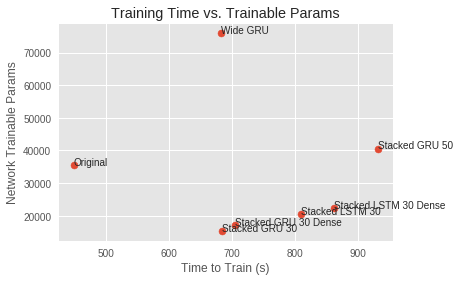

In [40]:
import matplotlib
matplotlib.style.use('ggplot')

# This is a plot to show the training time vs the number of trainable params in the model
models_names = ('Original', 'Wide GRU', 'Stacked GRU 30', 'Stacked GRU 50', 'Stacked LSTM 30','Stacked GRU 30 Dense', 'Stacked LSTM 30 Dense')
time =   [448,  682,  684, 931, 809, 704, 861]
params = [35602,75902,15362, 40602, 20462, 17222,22322]

fig, ax = plt.subplots()
ax.scatter(time, params)


for i, txt in enumerate(models_names):
    ax.annotate(txt, (time[i],params[i]))
plt.xlabel('Time to Train (s)')
plt.ylabel('Network Trainable Params')
plt.title('Training Time vs. Trainable Params')
plt.grid(True)
plt.show()

**Save the model and weights to files**

In [0]:
#import pickle

# there's an issue with keras saving custom layers
#model_json = model.to_json()
#with open("drive/Colab Notebooks/modelTemplate.json", "w") as json_file:
#    json_file.write(model_json)
#    print("Saved model to drive")

# serialize weights to HDF5
#model.save_weights(saved_model_weights)
#print("Saved weights to drive")

#with open(saved_model_history, 'wb') as file_pi:
#    pickle.dump(history.history, file_pi)
#    print("Saved history to drive")


**Show results of the training**

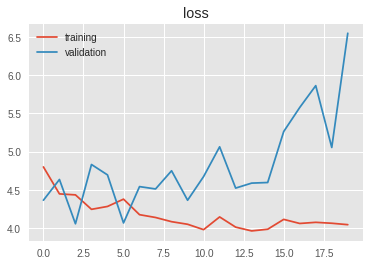

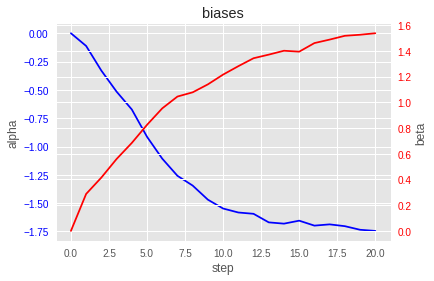

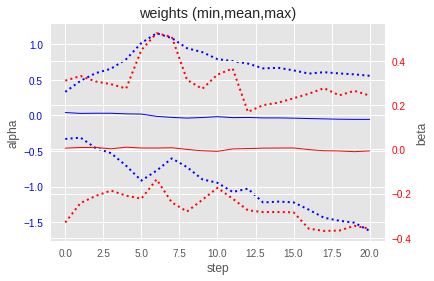

In [41]:
plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.title('loss')
plt.legend()

weightwatcher.plot()

**Use the model to make predictions**

In [0]:
# Make some predictions and put them alongside the real TTE and event indicator values
test_predict = model.predict(test_x)
test_predict = np.resize(test_predict, (100, 2))
test_result = np.concatenate((test_y, test_predict), axis=1)

**Show the accuracy of the prediction by comparing the mode of the distribution with the true value**

In [43]:
# This is the true value
test_y

,T,E
0,112,1
1,98,1
2,69,1
3,82,1
4,91,1
5,93,1
6,91,1
7,95,1
8,111,1
9,96,1


In [44]:
# this is the predicted alpha and beta defining the curve for the distribution
test_predict.shape

(100, 2)

In [45]:
test_predict

array([[172.73726  ,   7.8730493],
       [104.8578   ,   8.2290325],
       [ 80.87571  ,   8.445416 ],
       [ 91.82689  ,   8.226167 ],
       [108.729256 ,   7.9231157],
       [105.448494 ,   8.300106 ],
       [114.30293  ,   8.013905 ],
       [108.71852  ,   8.116277 ],
       [145.21666  ,   8.185981 ],
       [ 65.57904  ,   6.9850607],
       [112.55955  ,   8.389218 ],
       [ 80.42149  ,   7.273142 ],
       [102.87607  ,   8.087002 ],
       [153.239    ,   8.032351 ],
       [113.51684  ,   8.231962 ],
       [114.80776  ,   7.4136233],
       [ 56.652287 ,   7.8780785],
       [ 36.489418 ,   7.667372 ],
       [ 68.78913  ,   7.3747225],
       [ 16.426441 ,   6.1047997],
       [ 77.98159  ,   8.571306 ],
       [143.21236  ,   8.21521  ],
       [149.30121  ,   7.6390038],
       [ 25.351526 ,   7.7072606],
       [150.5782   ,   8.023695 ],
       [129.81537  ,   7.921415 ],
       [ 72.55814  ,   7.763436 ],
       [100.330864 ,   8.194782 ],
       [ 58.809772 ,

In [46]:
test_result.shape

(100, 4)

In [47]:
test_result

array([[112.        ,   1.        , 172.73725891,   7.87304926],
       [ 98.        ,   1.        , 104.85780334,   8.22903252],
       [ 69.        ,   1.        ,  80.87570953,   8.44541645],
       [ 82.        ,   1.        ,  91.82688904,   8.22616673],
       [ 91.        ,   1.        , 108.72925568,   7.92311573],
       [ 93.        ,   1.        , 105.44849396,   8.30010605],
       [ 91.        ,   1.        , 114.30293274,   8.01390457],
       [ 95.        ,   1.        , 108.71852112,   8.11627674],
       [111.        ,   1.        , 145.21665955,   8.1859808 ],
       [ 96.        ,   1.        ,  65.57904053,   6.98506069],
       [ 97.        ,   1.        , 112.55954742,   8.38921833],
       [124.        ,   1.        ,  80.42149353,   7.27314186],
       [ 95.        ,   1.        , 102.87606812,   8.0870018 ],
       [107.        ,   1.        , 153.23899841,   8.03235054],
       [ 83.        ,   1.        , 113.51683807,   8.2319622 ],
       [ 84.        ,   1

In [48]:
theTruth = test_y['T'].tolist()
theTruth

[112,
 98,
 69,
 82,
 91,
 93,
 91,
 95,
 111,
 96,
 97,
 124,
 95,
 107,
 83,
 84,
 50,
 28,
 87,
 16,
 57,
 111,
 113,
 20,
 145,
 119,
 66,
 97,
 90,
 115,
 8,
 48,
 106,
 7,
 11,
 19,
 21,
 50,
 142,
 28,
 18,
 10,
 59,
 109,
 114,
 47,
 135,
 92,
 21,
 79,
 114,
 29,
 26,
 97,
 137,
 15,
 103,
 37,
 114,
 100,
 21,
 54,
 72,
 28,
 128,
 14,
 77,
 8,
 121,
 94,
 118,
 50,
 131,
 126,
 113,
 10,
 34,
 107,
 63,
 90,
 8,
 9,
 137,
 58,
 118,
 89,
 116,
 115,
 136,
 28,
 38,
 20,
 85,
 55,
 128,
 137,
 82,
 59,
 117,
 20]

In [49]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)
  
def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)
  
def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)
test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])

test_results_df['T'].describe()


count    100.00000
mean      75.52000
std       41.76497
min        7.00000
25%       32.75000
50%       86.00000
75%      112.25000
max      145.00000
Name: T, dtype: float64

In [0]:

test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)
predictedModeValues = test_results_df['predicted_mode'].tolist()

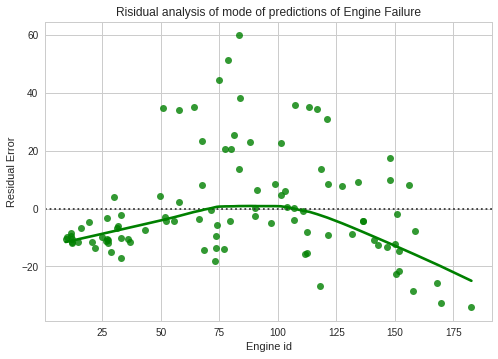

In [51]:
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

# List of data
prediced_list = predictedModeValues # [10, 20, 10, 50, 30, 40, 40, 33, 49, 10, 10, 50, 30, 40, 40, 10, 20, 10, 50, 30, 40, 40, 33, 49, 10, 10 ]
truth_list =  theTruth #  [13, 18, 13, 40, 33, 42, 41, 30, 30, 40, 13, 15, 13, 40, 20, 13, 40, 33, 49, 10, 50, 30, 40, 13, 15, 13 ]
predictions = np.array(prediced_list)
test = np.array(truth_list)

# Plot the residuals after fitting a linear model
r_ax = sns.residplot(predictions, test, lowess=True, color="g")
r_ax.set(ylabel='Residual Error', xlabel='Engine id')
plt.title('Risidual analysis of mode of predictions of Engine Failure')

plt.show()

In [52]:
# To compare the different models I use RMSE
# http://hamelg.blogspot.ie/2015/11/python-for-data-analysis-part-27-linear.html
# Root mean squared error (RMSE) is a common evaluation metric for predictions 
# involving real numbers. Root mean squared error is square root of the average of the squared error (residuals.). 

from sklearn.metrics import mean_squared_error

def rmse(predicted, targets):
    """
    Computes root mean squared error of two numpy ndarrays
    
    Args:
        predicted: an ndarray of predictions
        targets: an ndarray of target values
    
    Returns:
        The root mean squared error as a float
    """
    # use the scikit-learn library's mean squared error function and take the square root of the result
    return mean_squared_error(predicted, targets)**0.5

rmse(predictions, test)

21.832214179487888

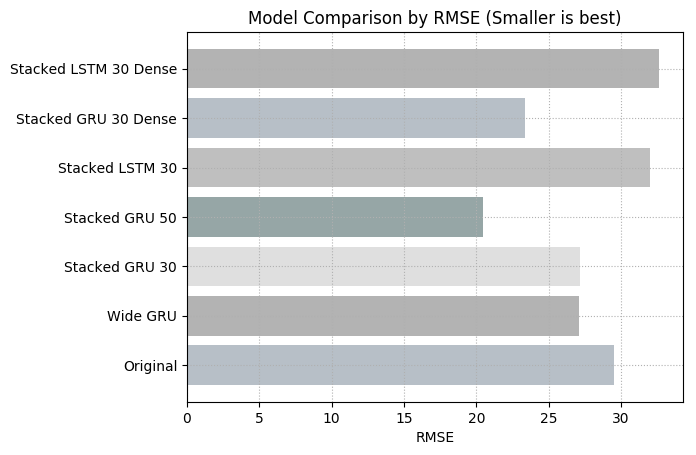

In [53]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')

 
colors = ['#708090', '#696969', '#C0C0C0', '#2F4F4F', '#808080']

objects = ('Original', 'Wide GRU', 'Stacked GRU 30', 'Stacked GRU 50', 'Stacked LSTM 30', 'Stacked GRU 30 Dense', 'Stacked LSTM 30 Dense')
y_pos = np.arange(len(objects))
performance = [ 29.53, 27.12, 27.18, 20.43, 32, 23.34, 32.65 ]
 
plt.barh(y_pos, performance, align='center', alpha=0.5,color=colors)
plt.yticks(y_pos, objects)
plt.xlabel('RMSE')
plt.title('Model Comparison by RMSE (Smaller is best)')
plt.grid(linestyle='dotted')

plt.show()

In [0]:
test_results_df['unit_number'] = np.arange(1, test_results_df.shape[0]+1)

In [55]:
test_results_df

,T,E,alpha,beta,predicted_mode,unit_number
0,112.0,1.0,172.737259,7.873049,169.782501,1
1,98.0,1.0,104.857803,8.229033,103.219783,2
2,69.0,1.0,80.875710,8.445416,79.677816,3
3,82.0,1.0,91.826889,8.226167,90.391404,4
4,91.0,1.0,108.729256,7.923116,106.893437,5
5,93.0,1.0,105.448494,8.300106,103.830049,6
6,91.0,1.0,114.302933,8.013905,112.417620,7
7,95.0,1.0,108.718521,8.116277,106.971429,8
8,111.0,1.0,145.216660,8.185981,142.923636,9
9,96.0,1.0,65.579041,6.985061,64.144380,10


alpha 83.9470847415924 beta 7.715263352394104


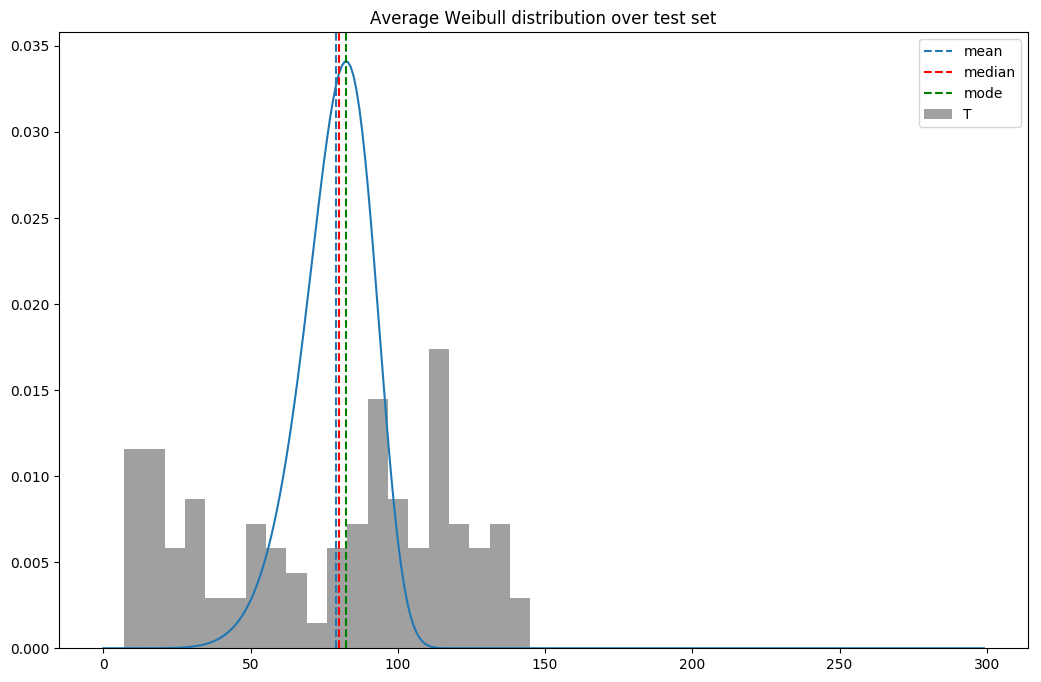

In [56]:
import math

t=np.arange(0,300)
alpha = test_results_df['alpha'].mean()
beta = test_results_df['beta'].mean()

plt.plot(t, weibull_pdf(alpha,beta, t))
mu = weibull_mean(alpha, beta)
median =weibull_median(alpha, beta)
mode = weibull_mode(alpha, beta)
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
n, bins, patches = plt.hist(test_results_df['T'], 20, normed=1, facecolor='grey', alpha=0.75, label='T')
plt.legend()

plt.gcf().set_size_inches(12.5, 8)
plt.title('Average Weibull distribution over test set')
print('alpha', alpha, 'beta', beta)

In [0]:
def plot_weibull_predictions(results_df):

    fig, axarr = plt.subplots(3, figsize=(20,30))

    t=np.arange(0,400)
#palette=sns.color_palette("Blues")
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
#sns.palplot(sns.color_palette(flatui))

#    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    palette = sns.color_palette(flatui, results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)

        color = color_dict[i]
        ax= axarr[0]
        mode = weibull_mode(alpha, beta)
        y_max = weibull_pdf(alpha, beta, mode)    

        ax.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
        ax.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')

        ax.set_title('Weibull distributions')
    
    ax=axarr[1]
    
    median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])
#     x = results_df['time']
    
#     ax.scatter(x, results_df['T'], label='survival_time', color='black')

#     ax.scatter(results_df['T'], median_predictions, label='median_prediction')
#     ax.scatter(results_df['T'], mean_predictions, label='mean_prediction')
    ax.scatter(results_df['T'], mode_predictions, label='m_prediction')
    ax.set_title('MAP prediction Vs. true')
    

    ax.legend()
    
    ax=axarr[2]
    sns.distplot(results_df['T'] - mode_predictions, ax=ax)
    ax.set_title('Error')

#     ax.plot(x, results_df['alpha'], label='alpha')
#     ax.legend()
    
#     ax = axarr[3]
#     ax.plot(x, results_df['beta'], label='beta')
#     ax.legend()
    
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.suptitle(title)
    plt.show()

In [58]:
train_orig.describe()

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [59]:
test_results_df.head()
test_results_df.loc[test_results_df['unit_number'] == 1]


,T,E,alpha,beta,predicted_mode,unit_number
0,112.0,1.0,172.737259,7.873049,169.782501,1


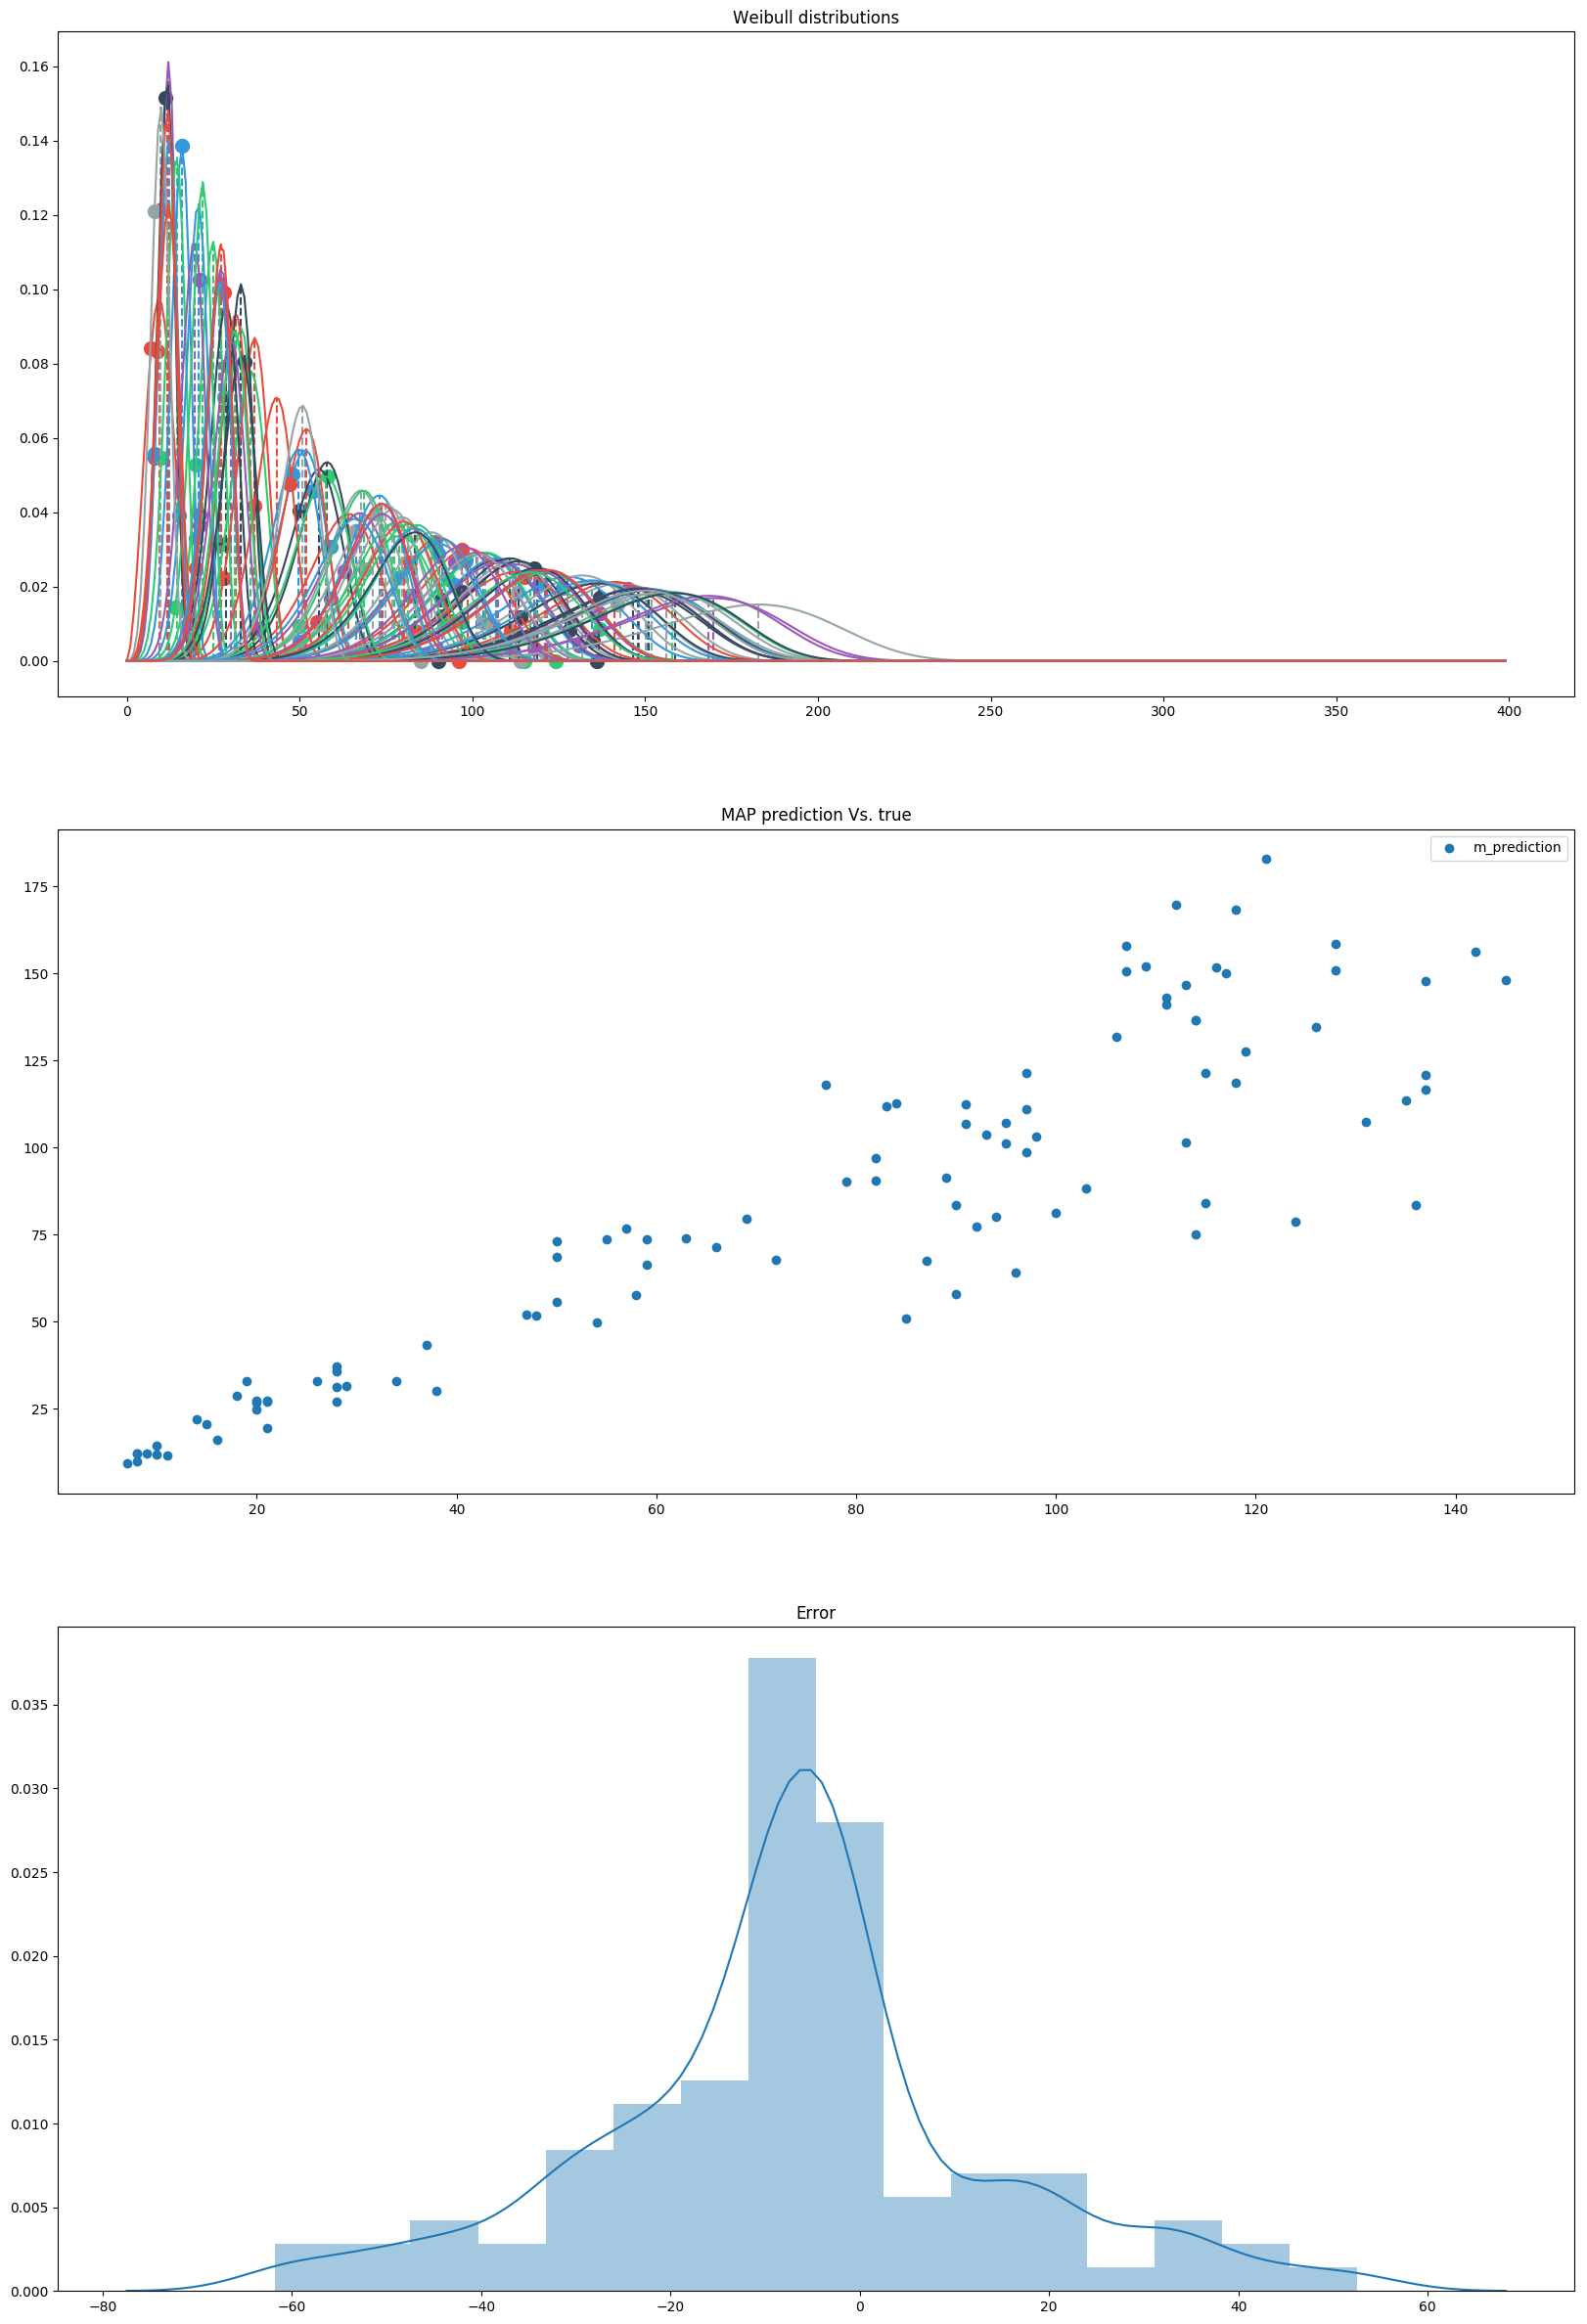

In [60]:
import seaborn as sns

plot_weibull_predictions(results_df=test_results_df)

In [0]:
test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
test_results_df['predicted_median'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

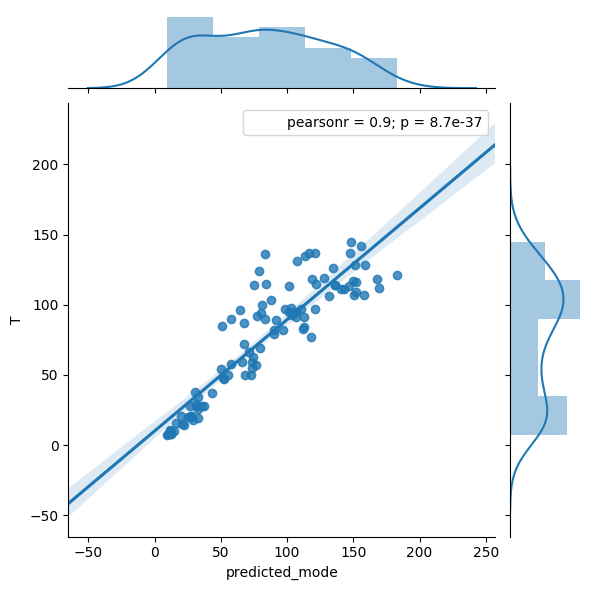

In [62]:
import seaborn as sns
sns.jointplot(data=test_results_df, y='T', x='predicted_mode',kind="reg")

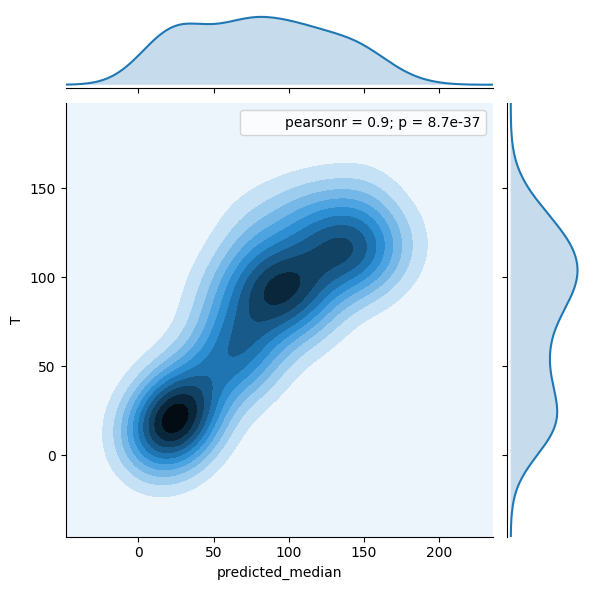

In [63]:
sns.jointplot(data=test_results_df, y='T', x='predicted_median',kind="kde" )

In [64]:
test_results_df['error'] = test_results_df['T']-test_results_df['predicted_median']
test_results_df['error'].describe()

count    100.000000
mean      -4.634063
std       20.178558
min      -56.437468
25%      -13.972326
50%       -4.988118
75%        1.863510
max       54.975188
Name: error, dtype: float64

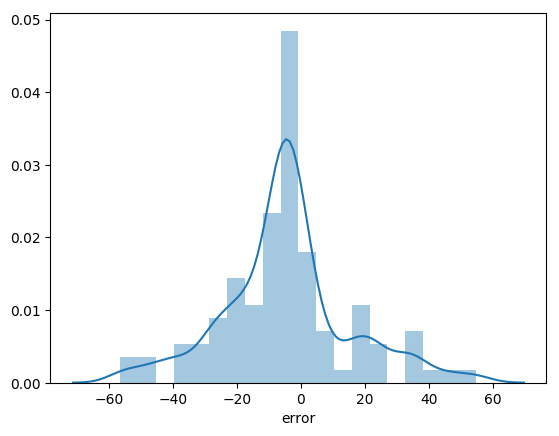

In [65]:
sns.distplot(test_results_df['error'], bins=20)

**Training evaluation**

In [66]:
test_y.shape


(100, 2)

In [67]:
train_y.shape


(20631, 2)

In [0]:
train_predict=model.predict(train_x)


In [0]:
train_predict = np.resize(train_predict, (20631, 2))
train_result = np.concatenate((train_y, train_predict), axis=1)

In [70]:
train_predict.shape


(20631, 2)

In [0]:
train_results_df = pd.DataFrame(train_result, columns=['T', 'E', 'alpha', 'beta'])


In [0]:
train_results_df[['unit_number', 'time']] = train_orig[['unit_number', 'time']]


In [73]:
train_results_df['unit_number'].nunique()


100

In [74]:
train_results_df.shape


(20631, 6)

In [75]:
train_results_df.groupby('unit_number')['beta'].describe()


,count,mean,std,min,25%,50%,75%,max
unit_number,,,,,,,,
1,192.0,7.286846,1.165262,1.752742,7.382828,7.633426,7.770186,8.452972
2,287.0,7.442014,1.173850,1.720040,7.368347,7.607369,7.910817,8.946439
3,179.0,7.583776,1.223879,1.697405,7.722957,7.965066,8.064451,8.793088
4,189.0,7.731880,1.422187,1.709144,7.904702,8.180956,8.361975,8.985477
5,269.0,7.716013,1.256044,1.689205,7.499955,7.752502,8.183216,10.973876
6,188.0,7.684858,1.459306,1.695392,7.938149,8.182300,8.266274,8.941214
7,259.0,7.662982,1.200644,1.722330,7.707998,7.819192,8.149065,9.484344
8,150.0,7.791599,1.452491,1.700733,7.981470,8.290245,8.416406,9.106085
9,201.0,7.540267,1.127781,1.689983,7.515861,7.911463,8.062802,8.719423


In [0]:
#for unit_number, grp in train_results_df.groupby('unit_number'):
    #plot_weibull_predictions(grp)
 #       plot_weibull_predictions(grp, unit_number)

In [0]:
train_results_df['predicted_mu'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
train_results_df['predicted_median'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)

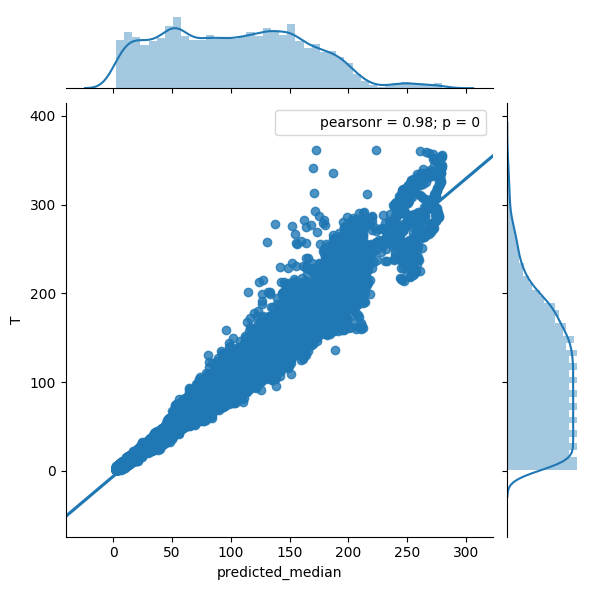

In [78]:
sns.jointplot(data=train_results_df, y='T', x='predicted_median',kind="reg")

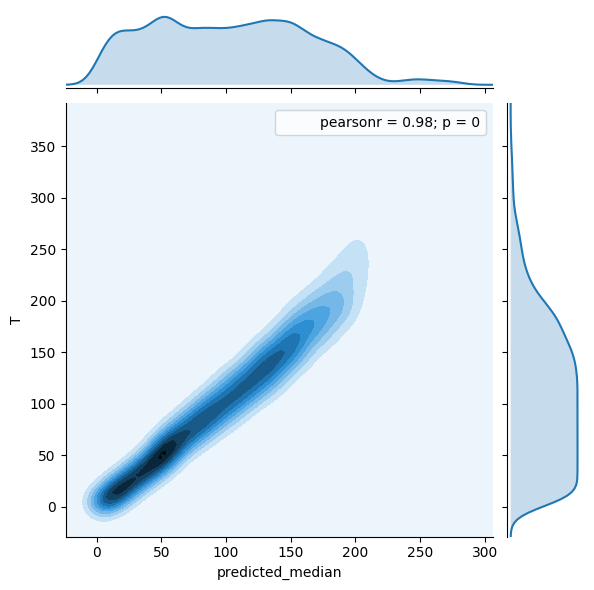

In [79]:
sns.jointplot(data=train_results_df, y='T', x='predicted_median',kind="kde" )


In [80]:
train_results_df['error'] = train_results_df['T']-train_results_df['predicted_median']
train_results_df['error'].describe()


count    20631.000000
mean         5.985216
std         15.898889
min        -52.602470
25%         -2.903092
50%          1.794908
75%         11.858392
max        189.575237
Name: error, dtype: float64

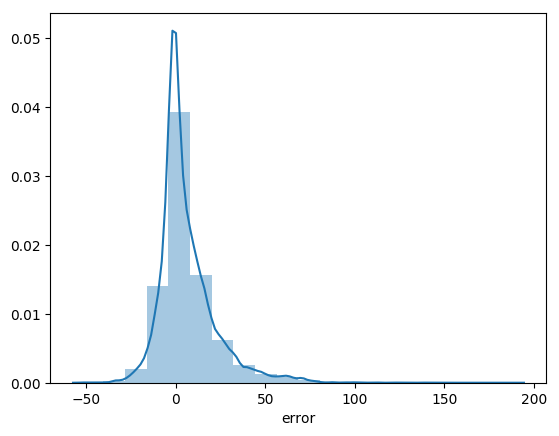

In [81]:
sns.distplot(train_results_df['error'], bins=20)
